``PROBLEM STATEMENT:``
========
* Implementing ``HUSE`` (Hierarchical Universal Semantic Embeddings)

## ``Technology used:``
* Pytorch

``PART 1:``
===================================================
Image Embeddings Input Model (10 points)
---------------------------------------------

You are free to use any pretrained image model for representing raw images into embedding space. Image embedding created from this part of the model are forwarded into the image tower for further processing. Here you will be tested on your skills to use transfer learning and image augmentation.

Text  Embeddings Input Model (10 points)
-------------------------------------------

You are free to use any pretrained text model for representing text into embedding space. Text embedding created from this part of the model are forwarded into the text tower for further processing. Here you will be tested on your skills to use transfer learning and text preprocessing.


``PART 2:``
==============================================================
Image Tower Model (10 points)
-------------------------------------------
It consists of sequence of dense and activation layers, for exact model description refer section 4 of the paper under the name Experiments . The final L2-normalized output is sent to a shared fully connected layer. You are required to build this part as it is, taking its input from image pretrained model of PART1.


Text Tower Model (10 points)
----------------------------------------
It consists of sequence of dense and activation layers, for exact model description refer section 4 of the paper under the name Experiments . The final L2-normalized output is sent to a shared fully connected layer. You are required to build this part as it is, taking its input from text pretrained model of PART1.

``Part 3``
================
Class Level Similarity (10 points)
-------------------------------
HUSE passes the embeddings from image tower and text tower through a shared fully connected layer and the model is trained using softmax cross entropy loss.

Semantic Similarity (30 points)
---------------------------

You are required to create a semantic graph, which consists of Adjacency matrix which is nothing but matrix of cosine distance between the textl embedding representation of individual classes. Such that if you have 5 unique classes, your adjacency matrix will be a 5x5 matrix consisting of cosine distance of text embedding of one class name with all other classes names. This matrix is used in calculating Semantic Similarity loss.

Cross Modal Gap (20 points)
----------------------------------------

You required to create a cross modal gap loss, which is the distance between image and text embeddings corresponding to the same product instance.

#### Importing ``Libraries``

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

import pandas as pd
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader

# For image embeddings
from img2vec_pytorch import Img2Vec
from PIL import Image

import tqdm
import re
from scipy.spatial.distance import cosine
from itertools import product

import numpy as np
import pandas as pd

### ``Data Overview``
* Creating a class ``ImageClassesDataset`` to load dataset

### ``References:``
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
# importing data
training = pd.read_csv('training.csv')

# Showing 65th row image_name , description, classes in data
n = 65
img_name = training.iloc[n, 0]
name = training.iloc[n, 1]
classes = training.iloc[n, 2]

print('Image name: {}'.format(img_name))
print('Description: {}'.format(name))
print('Classes: {}'.format(classes))

Image name: 5da81f696504fb65d41c583d_0.jpg
Description: Charlotte Tilbury  Hollywood Lips Matte Contour Liquid Lipstick – Show Girl  
Classes: beauty<makeup<lipstick


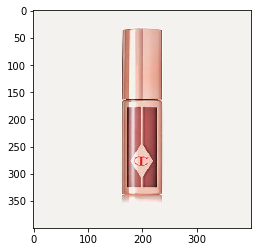

Description: Charlotte Tilbury  Hollywood Lips Matte Contour Liquid Lipstick – Show Girl  
Classes: beauty<makeup<lipstick


In [4]:
# Showing image of 65th data point

def show_classes(image,name,classes):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.show()
    print('Description: {}'.format(name))
    print('Classes: {}'.format(classes))

plt.figure()

show_classes(io.imread(os.path.join('images/', img_name)),name,
               classes)

In [5]:
class ImageClassesDataset(Dataset):
    """Imageclasses dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.training = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.training)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.training.iloc[idx, 0])
        image = io.imread(img_name)
        name = self.training.iloc[idx, 1]
        classes = self.training.iloc[idx,2]
        sample = {'image': image, 'name': name,'classes':classes}

        if self.transform:
            sample = self.transform(sample)

        return sample

``Intializing`` Class and representing few data points

0 (400, 400, 3)


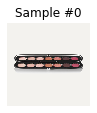

Description: Marc Jacobs Beauty  Eye-Conic Longwear Eyeshadow Palette - Scandalust 740  
Classes: beauty<makeup<eyeshadow
1 (400, 400, 3)


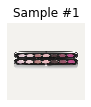

Description: Marc Jacobs Beauty  Eye-Conic Longwear Eyeshadow Palette - Provocouture 710  
Classes: beauty<makeup<eyeshadow
2 (400, 400, 3)


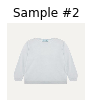

Description: Prada  Wool sweater   
Classes: clothing<knitwear<fine knit
3 (400, 400, 3)


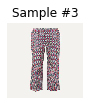

Description: Prada  Printed silk-satin twill straight-leg pants  
Classes: clothing<pants<straight leg


In [6]:
image_dataset = ImageClassesDataset(csv_file='training.csv',
                                    root_dir='images')

fig = plt.figure()

for i in range(4):
    sample = image_dataset[i]

    print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_classes(**sample)

    if i == 3:
        plt.show()
        break

## ``Part 1 (a)`` Data Augmentation:
* ``Recaling`` of image
* ``Random Crop`` of image
* ``Normalization`` of image with ``mean : `` [0.485, 0.456, 0.406], ``std : `` [0.229, 0.224, 0.225]

### `` References:``
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image,name,classes = sample['image'],sample['name'],sample['classes']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        # landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img,'name':name ,'classes': classes}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image,name,classes = sample['image'],sample['name'],sample['classes']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        #landmarks = landmarks - [left, top]

        return {'image': image,'name':name ,'classes': classes}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image,name,classes = sample['image'],sample['name'],sample['classes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),'name' :name ,'classes': classes}

Showing ``example`` on ``65th datapoint``

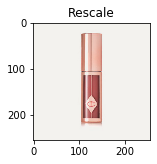

Description: Charlotte Tilbury  Hollywood Lips Matte Contour Liquid Lipstick – Show Girl  
Classes: beauty<makeup<lipstick


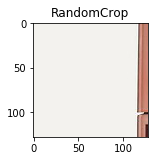

Description: Charlotte Tilbury  Hollywood Lips Matte Contour Liquid Lipstick – Show Girl  
Classes: beauty<makeup<lipstick


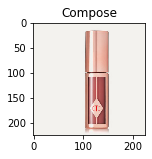

Description: Charlotte Tilbury  Hollywood Lips Matte Contour Liquid Lipstick – Show Girl  
Classes: beauty<makeup<lipstick


In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = image_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_classes(**transformed_sample)

plt.show()

In [9]:
transformed_dataset = ImageClassesDataset(csv_file='training.csv',
                                           root_dir='images',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['classes'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) beauty<makeup<eyeshadow
1 torch.Size([3, 224, 224]) beauty<makeup<eyeshadow
2 torch.Size([3, 224, 224]) clothing<knitwear<fine knit
3 torch.Size([3, 224, 224]) clothing<pants<straight leg


In [10]:
transformed_dataset[65]

{'image': tensor([[[0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
          [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
          [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
          ...,
          [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
          [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
          [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529]],
 
         [[0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
          [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
          [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
          ...,
          [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
          [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
          [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490]],
 
         [[0.9333, 0.9333, 0.9333,  ..., 0.9333, 0.9333, 0.9333],
          [0.9333, 0.9333, 0.9333,  ..., 0.9333, 0.9333, 0.9333],
          [0.9333, 0.9333, 0.93

``Part 1(a):`` Image Embeddings
-------------------------------------------

* Using ``resnet-18`` for image embeddings
* Returns a vector of length 512

### `` References :``
* https://github.com/christiansafka/img2vec


Showing a ``example``

In [11]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=True)

# Read in an image
img = Image.open('images/5da816f86504fb65cea6fed6_0.jpg')
# Get a vector from img2vec, returned as a torch FloatTensor
vec = img2vec.get_vec(img, tensor=False)
# Or submit a list
# vectors = img2vec.get_vec(list_of_PIL_images)

C:\Users\Tarun Makkar\Anaconda3\envs\keras-gpu\lib\site-packages\torchvision\transforms\transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [12]:
vec.shape

(512,)

Below code take ``2 hrs`` , So running it once and saving it to ``numpy file``



In [ ]:
image_embeddings = []
for image in tqdm.tqdm(os.listdir('images')):
    img = Image.open('images'+'/'+image)
    vec = img2vec.get_vec(img, tensor=False)
    image_embeddings.append(vec)

In [ ]:
np.save('image_embeddings.npy', image_embeddings, allow_pickle=True)

In [13]:
image_embeddings = np.load('image_embeddings.npy', allow_pickle=True)

``Part 1(b):`` Text Preprocessing
---------------------------------------------

* Preprocessing ``name`` feature
* Preprocessing includes: 
            * Removing spacial character,
            * removing stopwords
            * Coverting all characters into lowercase


In [20]:
training = pd.read_csv('training.csv')

In [21]:
print(training['name'][65])

Charlotte Tilbury  Hollywood Lips Matte Contour Liquid Lipstick – Show Girl  


In [22]:
sent = training['name'][65]

In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
sent = re.sub(r'[0-9]+',' ',sent)
print(sent)

Charlotte Tilbury Hollywood Lips Matte Contour Liquid Lipstick Show Girl 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [25]:
from tqdm import tqdm

In [26]:
"""Preprocessing Step"""

preprocessed_names = []
# tqdm is for printing the status bar
for i in tqdm(range(len(training))):
    sent = training['name'][i]
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = re.sub(r'[0-9]+',' ',sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_names.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 65714/65714 [00:02<00:00, 31923.37it/s]


In [27]:
preprocessed_names[65]

'charlotte tilbury hollywood lips matte contour liquid lipstick show girl'

``Part 1(b):`` Text Embeddings
-------------------------------------------

* Downloading ``glove.840B.300d.txt`` from https://nlp.stanford.edu/projects/glove/
* Converting ``glove`` file to ``word2vec`` format
* Loading word2vec model using ``gensim``
* Using ``Stanford gloVe`` i.e a pretrained model
* And encoding ``name``feature with ``TFIDF weighted-word2vec``
* Saving embeddings to numpy file

``TFIDF`` weighted-word2vec
---

For eg - 
 
Sentence = Computer is electronic device

preprocessed_dev = Computer electronic device

    w1 = Computer 
    w2 = electronin
    w3 = device

Result = 
    # tfidf(w1)*glove(w1) + tfidf(w2)*glove(w2) + tfidf(w3)*glove(w3) / (tfidf(w1)+tfidf(w2)+ tfdif(w3))


### `` References:``
* https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
* https://github.com/makkarss929/KNN-on-Donor-Choose-Dataset/blob/master/KNN_SUBMIT.ipynb

Saving ``glove file`` in ``word2vec`` format

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.840B.300d.txt'
word2vec_output_file = 'glove.840B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

Loading ``glove`` model using ``gensim``

In [33]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.840B.300d.txt.word2vec'
glove_w2v = KeyedVectors.load_word2vec_format(filename, binary=False)

#### TFIDF Weighted ``Word2Vec``

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_names)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

``Tfidf with glove`` take ``10 hrs`` to execute

In [ ]:
# Compute tfidf weighted word2vec for each point
preprocessed_names_tfidf_wt_w2v_vectors = []
for sentence in tqdm(preprocessed_names): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in list(glove_w2v.wv.vocab)) and (word in tfidf_words):
            vec = glove_w2v[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    preprocessed_names_tfidf_wt_w2v_vectors.append(vector)

print(len(preprocessed_names_tfidf_wt_w2v_vectors))
print(len(preprocessed_names_tfidf_wt_w2v_vectors[0]))

Saving ``Text embeddings`` to numpy file

In [ ]:
np.save('text_embeddings.npy', preprocessed_names_tfidf_wt_w2v_vectors, allow_pickle=True)

In [2]:
text_embeddings = np.load('text_embeddings.npy', allow_pickle=True)

In [3]:
text_embeddings = torch.from_numpy(text_embeddings)

In [4]:
image_embeddings = np.load('image_embeddings.npy', allow_pickle=True)

In [5]:
image_embeddings = torch.from_numpy(image_embeddings)

``Part 3(b): `` Label Embeddings (Semantic Similarity)
---------------------------
* ``Label Embeddings`` used for ``Semantic Similarity``
* ``One hot encoding`` labels for compution of ``class level similarity``
* Using ``InferSent : Facebook's pretrained model`` for compution of ``semantic similarity``
* Downloading ``InferSent1.pkl`` from https://dl.fbaipublicfiles.com/infersent/infersent1.pkl 
* ``InferSent1.pkl`` contains pretrained weights
* Loading Model using pretrained weights,creating vocab and encoding
* Returns ``4096 dim`` of each label


### ``References :``
* https://github.com/facebookresearch/InferSent

In [6]:
filename = 'training.csv'
mapping_csv = pd.read_csv(filename)

Create a ``set`` of ``labels`` and ``sorting`` it alphabetically

In [7]:
# create a set of labels
labels = set()
for i in range(len(mapping_csv)):
	# convert spaced separated tags into an array of tags
	tags = mapping_csv['classes'][i].split('<')
	# add tags to the set of known labels
	labels.update(tags)

In [8]:
# convert set of labels to a list to list
labels = list(labels)
# order set alphabetically
labels.sort()

In [9]:
len(labels)

67

``Note :`` There are 67 unique labels

### ``Labels mapping``
* Each ``label`` is assigned a ``unique number``. 

In [10]:
# dict that maps labels to integers, and the reverse
labels_map = {labels[i]:i for i in range(len(labels))}
inv_labels_map = {i:labels[i] for i in range(len(labels))}

### Part 3(a): ``One hot encoding`` for class level similarity

In [11]:
def one_hot_encode(tags, mapping):
	# create empty vector
	encoding = np.zeros(len(mapping), dtype='uint8')
	# mark 1 for each tag in the vector
	for tag in tags:
		encoding[mapping[tag]] = 1
	return encoding

Showing ``Example``

In [12]:
tags = mapping_csv['classes'][65].split('<')

In [13]:
one_hot_encode(tags,labels_map)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=uint8)

In [14]:
one_hot_labels = []
for i in range(len(mapping_csv)):
    tags = mapping_csv['classes'][i].split('<')
    one_hot_labels.append(one_hot_encode(tags,labels_map))

In [15]:
one_hot_labels = torch.from_numpy(np.array(one_hot_labels))

In [16]:
one_hot_labels.size()

torch.Size([65714, 67])

``Labels embeddings``
----------------------
* Constructing label embedding using ``InferSent : Facebook's Pretrained Model``
* Returns embedding of 4096 dimension.

Loading ``InferSent``

In [17]:
import InferSent

In [18]:
from InferSent import models

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Tarun
[nltk_data]     Makkar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Loading ``InferSent1.pkl`` : pretrained weights 

In [20]:
# Load model
#from models import InferSent
model_version = 1
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = models.InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [21]:
# Keep it on CPU or put it on GPU
use_cuda = False
model = model.cuda() if use_cuda else model

``InferSent`` uses ``glove`` file

In [22]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

Updating ``Vocabulary`` using ``Labels``

In [23]:
sentences = labels

In [24]:
# Load embeddings of K most frequent words
model.build_vocab(sentences,tokenize=True)

Found 76(/76) words with w2v vectors
Vocab size : 76


In [25]:
[inv_labels_map[0]]

['accessories']

Showing example of `` accessories``

In [26]:
model.encode([inv_labels_map[0]])[0]

array([ 0.11502168, -0.06020666, -0.0304451 , ..., -0.03926746,
       -0.03814262, -0.0289226 ], dtype=float32)

### ``Part 3(b):``Adjacency Matrix (Semantic Similarity)
* Constructing Adjacency matrix for ``semantic graph``
* Taking each ``label Embeddings`` as node and ``edge weight`` is cosine distance between 2 nodes


In [27]:
emb = model.encode(labels,tokenize = True)

emb.shape

(67, 4096)

In [28]:
A = np.zeros((len(labels),len(labels)))
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        A[i][j] = cosine(emb[i],emb[j])

In [29]:
print(A)

[[0.         0.65449536 0.38661617 ... 0.41142404 0.46810478 0.63951567]
 [0.65449536 0.         0.61885324 ... 0.62294078 0.60166988 0.34177005]
 [0.38661617 0.61885324 0.         ... 0.10404348 0.32019562 0.62520388]
 ...
 [0.41142404 0.62294078 0.10404348 ... 0.         0.30119473 0.61426258]
 [0.46810478 0.60166988 0.32019562 ... 0.30119473 0.         0.59520289]
 [0.63951567 0.34177005 0.62520388 ... 0.61426258 0.59520289 0.        ]]


``Part 2 :`` Defining Model Architecture
----------------
* Implementing ``Image Tower`` and ``Text Tower``.

* ``The image tower`` consists of ``5 hidden layers`` of ``512 hidden units`` each.

* ``Text tower consists`` of ``2 hidden layers`` of ``512 hidden units`` each.  
* A ``dropout`` of ``0.15`` is used between all hidden layers of ``both towers``. 
* ``Both Towers`` consists of ``RELU`` non-linearity .
* ``5th Layer`` of both towers should have ``same dimension`` as it ``shared hidden layer.``
* The network is trained using the ``RMSProp optimizer`` with a ``learning rate`` of ``1.6192e-05``and  ``momentum``  set  to  ``0.9``  with  random  batches  of  1024 for 250,000 steps.  

``Shared Hidden Layer``(Late Fusion)
----------------------------------
* Last layer of both Towers is ``512``units.
* ``Concatenating`` Last hidden Layers from ``both towers``.
* After ``Concatenation`` it becomes ``1024``.
* Then adding ``Extra Layer`` on ``concatenated Layer`` of ``512`` units.

In [30]:
import torch.nn.functional as F

In [31]:
class HUSE(nn.Module):
    def __init__(self):
        super(HUSE, self).__init__()
        
        # Image Tower
        self.image_tower = nn.Sequential(
            # 1st Layer 
            nn.Linear(512,512),  # (N,512) -> (N,512)
            nn.Dropout(0.15),
            nn.ReLU(),
            # 2nd Layer 
            nn.Linear(512,512),  # (N,512) -> (N,512)
            nn.Dropout(0.15),
            nn.ReLU(),
            # 3rd Layer
            nn.Linear(512,512),  # (N,512) -> (N,512)
            nn.Dropout(0.15),
            nn.ReLU(),
            # 4th Layer
            nn.Linear(512,512),  # (N,512) -> (N,512)
            nn.Dropout(0.15),
            nn.ReLU(),
            # L2 Normalization 
            # nn.LayerNorm(512)
        
            )
        
        # Text Tower
        self.text_tower = nn.Sequential(
            # 1st Layer
            nn.Linear(300,512),  # (N,300) -> (N,512)
            nn.Dropout(0.15),
            nn.ReLU(),
            # L2 Normalization
            # nn.LayerNorm(512)
            )  
        
        self.shared_hidden_layer = nn.Sequential(
            # Last Shared Layer
            nn.Linear(1024,512),
            nn.Dropout(0.15),
            nn.ReLU(),
            )
        self.shared_output_layer = nn.Sequential(
            nn.Linear(512,67),
            nn.Dropout(0.15),
            nn.ReLU(),
            )
        
        self.softmax = nn.Softmax(dim=0)
        
    # Cross Modal Similarity
    
    
        
    # Cross entropy Similarity 
    def cross_entropy(self,predictions, targets):
        # Converting into numpy
        
        predictions = predictions.detach().numpy()
        targets = targets.detach().numpy()
        
        N = predictions.shape[0]
        ce = -np.sum(targets * np.log(predictions)) / N
        
        # Converting back to tensor
        ce = np.array(ce)
        ce = torch.from_numpy(ce)
        return ce
    
    # Semantic Similarity
    def semantic_similarity(self,phi,A):
        
        # Converting to numpy array
        phi = phi.detach().numpy()
        
        
        D = np.zeros(A.shape)
        sigma = np.zeros(A.shape)
        threshold = 1

        for m in tqdm(range(phi.shape[0])):
            for i in range(phi.shape[1]):
                for n in range(phi.shape[0]):
                    for j in range(phi.shape[1]):
                        D[i][j] = (cosine(phi[m][i],phi[n][j]))
                        sigma[i][j] = 1.0 if (A[i][j]<threshold and D[i][j] < threshold) else 0.0

        N = phi.shape[0]
        result =  np.sum(sigma*((D - A)**2))/(N**2)
        result = np.array(result)
        
        result = torch.from_numpy(result)
        
        return result
        
            
    def forward(self,x1,x2):
        #Calling Image Tower
        x1 = self.image_tower(x1)
        # L2 Normalization 
        x1 = F.normalize(x1)
        
        #Calling Text Tower
        x2 = self.text_tower(x2)
        # L2 normalization
        x2 = F.normalize(x2)
        
        
        # Late Fusion 
        x = torch.cat((x1,x2),dim = 1)
        # Shared hidden layer
        x = self.shared_hidden_layer(x)
        # Unnormalized output layer
        x = self.shared_output_layer(x)
        
        # Softmax on Unnormalized output layer
        # x = F.softmax(x, dim=0)
        x = self.softmax(x)
        return x

In [32]:
net = HUSE()

``Part 3(a):`` Class level similarity
------
* Loading ``BinaryCrossEntropyLoss`` from torch.nn
* Using it for calculating ``loss`` between ``One hot labels`` and ``predicted labels.``


``Part 3(c):`` Cross Modal gap
-----
* Using `` torch.nn.CosineSimilarity`` for calculating Cross Modal gap.
* As we now,

     ### cosine distance = (1 - cosine similarity) 
    
    
 

* Using ``above equation``, we calculate this loss

Loading ``Loss functions`` and ``Optimizers``

In [33]:
loss_fn_1 = nn.BCELoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=1.6192e-05, momentum =0.9)

#### Loading ``weights`` of loss function:
* ``alpha`` for ``class level similarity``
* ``beta`` for ``semantic similarity ``
* ``gamma`` for ``cross modal gap``

``Part 3:`` Total Loss Function
----
* Weighted Average of all 3 losses:
         Total loss = alpha * class_level_similarity  + beta * semantic_similarity + gamma * cross_modal_gap

In [34]:
alpha = 10
gamma = 1
beta = 2

#### ``Note`` : Giving more ``weightage`` to ``class level similarity``

### Intializing few ``parameters``:
* Number of epochs.
* Batch_size

### ``Training`` our Model: 
    # Number of epochs = 1000
    # Batch_size = 128

Epoch: 199/1000,Total Loss : 1.92 ,Class Similarity Loss : 0.18, Cross Modal Loss: 0.17


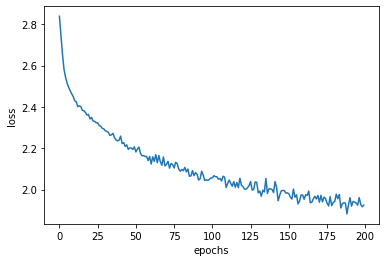

Epoch: 399/1000,Total Loss : 1.85 ,Class Similarity Loss : 0.17, Cross Modal Loss: 0.17


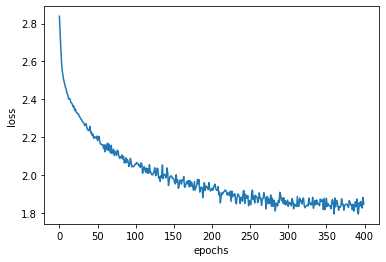

Epoch: 599/1000,Total Loss : 1.82 ,Class Similarity Loss : 0.17, Cross Modal Loss: 0.16


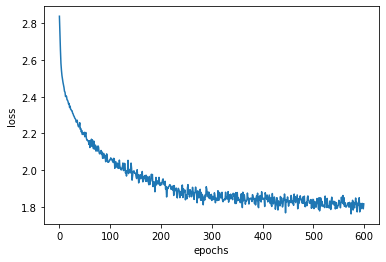

Epoch: 799/1000,Total Loss : 1.79 ,Class Similarity Loss : 0.16, Cross Modal Loss: 0.16


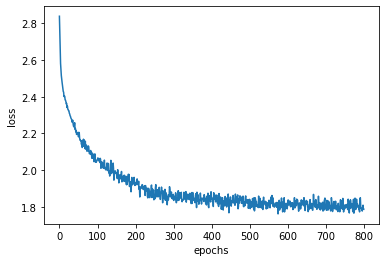

Epoch: 999/1000,Total Loss : 1.78 ,Class Similarity Loss : 0.16, Cross Modal Loss: 0.16


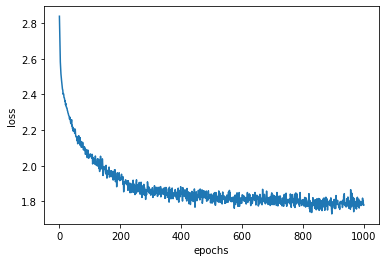

In [36]:
n_epochs = 1000
batch_size = 128
loss_arr = []
loss_epoch_arr = []
X = image_embeddings

for epoch in range(n_epochs):

    # X is a torch Variable
    permutation = torch.randperm(X.size()[0])

    for i in range(0,X.size()[0], batch_size):
        

        indices = permutation[i:i+batch_size]
        
        image_embeddings, text_embeddings,one_hot_labels = image_embeddings[indices],text_embeddings[indices],one_hot_labels[indices]
        
        #move inputs to gpu
        
        #inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        phi_I = net.image_tower(image_embeddings)

        phi_T = net.text_tower(text_embeddings.float())


        phi = net.shared_hidden_layer(torch.cat((phi_I,phi_T),dim = 1))


        z = net.shared_output_layer(phi)

        outputs = net.softmax(z)

        loss_class_similarity = loss_fn_1(outputs,one_hot_labels.float())

        #loss_semantic_similarity = net.semantic_similarity(z,A)

        loss_cross_modal_gap = torch.sum(1 - F.cosine_similarity(phi_I,phi_T))/phi_I.size(0)

        loss = (alpha*loss_class_similarity + gamma*loss_cross_modal_gap )

        loss.backward()

        optimizer.step()
        
        loss_arr.append(loss.item())

    loss_epoch_arr.append(loss.item())

    
    if (epoch+1)%200 == 0:
        print('Epoch: %d/%d,Total Loss : %0.2f ,Class Similarity Loss : %0.2f, Cross Modal Loss: %0.2f' % (epoch,n_epochs ,loss,loss_class_similarity,loss_cross_modal_gap))

        plt.plot(loss_epoch_arr)
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title("")
        plt.show();

Only taking ``50 points`` to calculate ``semantic similarity``

``Part 3(b) :`` Semantic Similarity
---
* ``Showing example`` to compute ``semantic similarity`` on ``50 points``


### ``Note :``

We are not taking ``semantic loss`` in ``training`` because it takes ``lot of time`` to compute.For ``1 batch(128 points)`` it takes ``1 hr``.

In [84]:
out_I = net.image_tower(image_embeddings[:50,:])        
out_T = net.text_tower(text_embeddings[:50,:].float())    
out = net.shared_hidden_layer(torch.cat((out_I,out_T),dim = 1))
z = net.shared_output_layer(out)
outputs = net.softmax(z)

In [85]:
b = list(product(range(z.size(0)),range(z.size(1)),range(z.size(0)),range(z.size(1))))

In [95]:
def semantic_similarity(z,A):
    # This Code calculates 
    
    phi = z.detach().numpy()
    
    D = np.zeros((50,67,50,67))
    R = np.zeros((50,67,50,67))
    sigma = np.zeros((50,67,50,67))
    threshold = 2.0
    
    for m,i,n,j in b:
        D[m][i][n][j] = cosine(phi[m][i],phi[n][j])
        R[m][i][n][j] = np.power((D[m][i][n][j] - A[i][j]),2)
        sigma[m][i][n][j] = 1.0 if ((A[i][j]< threshold) and (D[m][i][n][j] < threshold)) else 0.0
    
    return (np.sum(sigma*R))/(50**2)

loss = semantic_similarity(z,A)

In [97]:
print(loss)

4.34


### Showing ``accuracy`` on 1 batch i.e 128 points

In [37]:
out_I = net.image_tower(image_embeddings)        
out_T = net.text_tower(text_embeddings.float())    
out = net.shared_hidden_layer(torch.cat((out_I,out_T),dim = 1))
z = net.shared_output_layer(out)
outputs = net.softmax(z)
truth_labels = one_hot_labels

In [38]:
def accuracy(predicted_values,truth_values):
    count = 0
    for x,y in zip(truth_values,predicted_values):
        x = torch.argsort(x)[-3:]
        x = torch.sort(x).values
        y = torch.argsort(y)[-3:]
        y = torch.sort(y).values
        
        if torch.sum(x == y) == 3:
            count +=3
        elif torch.sum(x == y) == 2:
            count +=2
        elif torch.sum(x == y) == 1:
            count +=1
        
    acc = (count)/(truth_values.size(0)*3)
    return acc

In [39]:
accuracy(outputs,truth_labels)

0.5442708333333334

``Conclusion:``
-----
* Total loss is reduce from 3.5 to 1.69
* Cross modal gap is 0.15.
* Class level similarity loss is 0.16.
* Accuracy is 62.5